# Задача

Задача 2 двухмерная модель Изинга на странице 8 в ["Python. Список задач 5. Модель Изинга, алгоритм Метрополиса"](http://theor.mephi.ru/wiki/images/b/b8/Python_problem_set_5.pdf).

Двухмерная модель Изинга:

$$x_{i, \ j} = \pm 1$$

$$h = B g \mu_b$$

$$E(x) = - J \sum_{i, \ j} \left(x_{i + 1, \ j} + x_{i, \ j + 1}\right) x_{i, \ j} - h \sum_{i, \ j} x_{i, \ j}$$

$$M(x) = \frac 1 N \sum_{i, \ j} x_{i, \ j}$$

# Решение

In [1]:
from numpy import *
import numba as nb
import matplotlib.pyplot as plt
# from numba import cuda
%load_ext line_profiler
%matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight'}

Символьно предвычисленные выражения для ускорения алгоритма Метрополиса:
$$\Delta E_{i, \ j} = 2 J \left( x_{i - 1, \ j} + x_{i, \ j - 1} + x_{i + 1, \ j} + x_{i, \ j + 1} \right) x_{i, \ j} + 2 h x_{i, \ j}$$

$$\Delta M_{i, \ j} = - 2 \frac 1 N x_{i, \ j}$$

In [2]:
%%time
@nb.njit('(int64[:, ::1], float64[::1], int64, int64, int64, int64)', parallel=True)
def calc_model_nb(x, T_level, n_step, window, J, h):
    k_Boltzmann = 1

    n_side = x.shape[0]
    n_particles = count_nonzero(x)
    n_level = T_level.shape[0]
    E_level = empty(n_level)
    C_level = empty(n_level)
    M_level = empty(n_level)

    E0 = - J * ((x[:-1, 1:] + x[1:, :-1]) * x[:-1, :-1]).sum() - h * x.sum()
    M0 = x.sum() / n_particles

    E = empty(n_step * n_side * n_side)
    M = empty(n_step * n_side * n_side)
    E[-1] = E0
    M[-1] = M0
    
    ij_white = array([(i, j) for i in range(n_side) for j in range(n_side) if (i + j) % 2 == 0])
    iw = ij_white[:, 0]
    jw = ij_white[:, 1]

    ij_black = array([(i, j) for i in range(n_side) for j in range(n_side) if (i + j) % 2 == 1])
    ib = ij_black[:, 0]
    jb = ij_black[:, 1]

    for l in range(n_level):
        T = T_level[l]
        p = 0

        for _ in range(n_step):
            i_ = iw
            j_ = jw
            for k in nb.prange(i_.shape[0]):
                i, j = i_[k], j_[k]

                # \Delta E = E_{tr} - E
                dE = 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j]
                dM = - 2 * x[i, j] / n_particles

                if dE <= 0:
                    x[i, j] = - x[i, j]
                else:
                    R = exp(- dE / k_Boltzmann / T)
                    if random.rand() <= R:
                        x[i, j] = - x[i, j]
                    else:
                        dE = 0
                        dM = 0

                E[p] = E[p - 1] + dE
                M[p] = M[p - 1] + dM
                p += 1

            i_ = ib
            j_ = jb
            for k in nb.prange(i_.shape[0]):
                i, j = i_[k], j_[k]

                # \Delta E = E_{tr} - E
                dE = 2 * J * (x[i - 1, j] + x[i, j - 1] + x[i + 1, j] + x[i, j + 1]) * x[i, j] + 2 * h * x[i, j]
                dM = - 2 * x[i, j] / n_particles

                if dE <= 0:
                    x[i, j] = - x[i, j]
                else:
                    R = exp(- dE / k_Boltzmann / T)
                    if random.rand() <= R:
                        x[i, j] = - x[i, j]
                    else:
                        dE = 0
                        dM = 0

                E[p] = E[p - 1] + dE
                M[p] = M[p - 1] + dM
                p += 1

        aE = E[- window:].sum() / window
        aM = M[- window:].sum() / window
        aE2 = (E[- window:] * E[- window:]).sum() / window
        E_level[l] = aE
        C_level[l] = (aE2 - aE * aE) / n_particles / k_Boltzmann / T / T
        M_level[l] = aM

    return E_level, C_level, M_level

CPU times: user 10.2 s, sys: 63 ms, total: 10.3 s
Wall time: 10.3 s


In [ ]:
# ----------
n_side = 400
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side
n_steps = 10 * n_particles

# ----------
n = n_side
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # hot
x = full((n + 2, n + 2), 1)  # cold
x[0, :] = 0
x[:, 0] = 0
x[n + 1, :] = 0
x[:, n + 1] = 0

# ----------
n_level = 200
n_step = 1000000
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

В ячейке выше происходит падение с сообщением:

The kernel for projects/repo/others/ising_model-checkerboard.ipynb appears to have died. It will restart automatically.

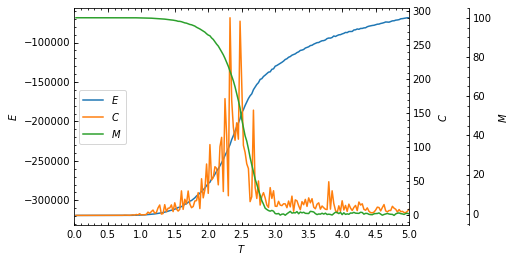

In [88]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in (host, par1, par2):
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

Темплоемкость расходится в точке Кюри $T = T_c \approx 2.269185 J$. На графике темплоемкости $C(T)$ приблизительно в $T_c$ наблюдается резкий пик.

Повышение погрешности в окрестности точки Кюри является проблемой критического замедления. Метод параллельного отжига служит решением данной проблемы.  Информация по проблеме критического замедления и методу параллельного отжига есть в материале [Методы канонического и мультиканонического семплирования пространства состояний векторных моделей](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=dvmg&paperid=346&option_lang=rus).

Все потоки процессора не были загружены полностью в процессе расчета модели. Только один поток был полностью загружен. Для полноценной загрузки всех потоков планируется заменить схему решения на ту схему, которая пригодна для распараллеливания на потоки процессора, и распараллелить схему решения с помощью библиотеки для векторных вычислений Numpy на Python. Предположительно, пригодная для данного распараллеливания схема есть в материалах:
* [High Performance Calculation of Magnetic Properties and Simulation of Nonequilibrium Phenomena in Nanofilms](https://www.researchgate.net/publication/225045639_High_Performance_Calculation_of_Magnetic_Properties_and_Simulation_of_Nonequilibrium_Phenomena_in_Nanofilms)
* [Расчет магнитных свойств наноструктурных пленок методом параллельного Монте-Карло ](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=crm&paperid=428&option_lang=rus)
* [A Performance Study of the 2D Ising Model on GPUs](https://arxiv.org/abs/1906.06297)

In [5]:
# ----------
n_side = 40
J = 1
B = 0
g = 1
mu_b = 1
k_Boltzmann = 1
h = B * g * mu_b

n_particles = n_side * n_side
n_step = 10 #* n_particles

# ----------
n = n_side
# x = random.randint(2, size=(n + 2, n + 2)) * 2 - 1  # hot
x = full((n + 2, n + 2), 1)  # cold
x[0, :] = 0
x[:, 0] = 0
x[n + 1, :] = 0
x[:, n + 1] = 0

# ----------
n_level = 50
# n_step = 10000
window = round(5 / 6 * n_step)
T = linspace(0, 5, n_level + 1)[1:]
E, C, M = %time calc_model_nb(x, T, n_step, window, J, h)

CPU times: user 884 ms, sys: 287 µs, total: 884 ms
Wall time: 328 ms


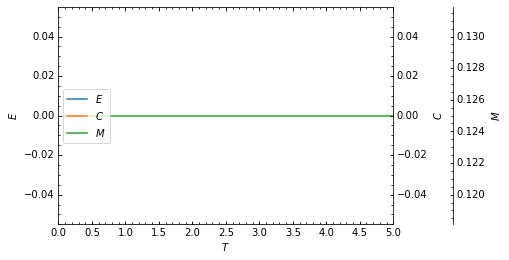

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.plot(T, E, label="$E$")
par1.plot(T, C, label="$C$")
par2.plot(T, M, label="$M$")

host.set_xlabel("$T$")
host.set_ylabel("$E$")
par1.set_ylabel("$C$")
par2.set_ylabel("$M$")

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
host.xaxis.set_major_locator(MultipleLocator(0.5))
host.xaxis.set_minor_locator(AutoMinorLocator())
for ax in (host, par1, par2):
    ax.yaxis.set_minor_locator(AutoMinorLocator())

host.set_xlim(0, 5)

host.legend(loc='center left')
plt.show()

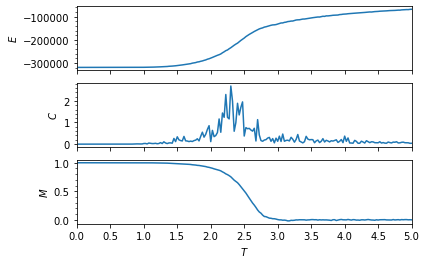

In [9]:
a, b = 1, 1
fig, (axE, axC, axM) = plt.subplots(3, 1, sharex=True, figsize=(a * 6, b * 4))
axM.set_xlabel('$T$')  # Температура
axE.set_ylabel('$E$')  # Энергия
axC.set_ylabel('$C$')  # Темплоемкость
axM.set_ylabel('$M$')  # Намагниченность
axE.plot(T, E)
axC.plot(T, C)
axM.plot(T, M)
axM.set_xlim(0, 5)

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
axM.xaxis.set_major_locator(MultipleLocator(0.5))
axM.xaxis.set_minor_locator(AutoMinorLocator())
for ax in (axM, axE, axC):
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.show()